# Find optimal parameters for the original aggregation method

## Set up

Set up the code

In [25]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss
import scipy.optimize as optimize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Local imports
from src import process
from src import util
from src import plot

data_path = process.DEFAULT_DATA_PATH

In [27]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)

In [28]:
# Mean estimate by group
mean_ests = np.array(estimates_df.mean(axis=0))
mean_ests_SF = np.array(
    estimates_df.loc[blind_mode_df["Superforecaster"].values == "Yes"].mean(axis=0)
)
mean_ests_FE = np.array(
    estimates_df.loc[blind_mode_df["ForecastingExperience"].values == "Yes"].mean(
        axis=0
    )
)
mean_ests_LW = np.array(
    estimates_df.loc[blind_mode_df["LessWrong"].values == "Yes"].mean(axis=0)
)

## Evaluate original aggregation method

In [29]:
# Find the best individual score
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
blind_mode_final_brier = np.mean(
    np.square(estimates_matrix - resolution_vector), axis=1
)
best_individual_brier = np.min(blind_mode_final_brier)
print("Best individual brier score:", best_individual_brier)

Best individual brier score: 0.11796399999999997


In [30]:
# Original aggregate prediction (verified to match 3_manifold.ipynb)
weights_original = [0.05, 0.8, 0.1, 0.05]
beta_a = 1 / 3
beta_b = 1 / 3
x0_original = weights_original + [beta_a, beta_b]
score = util.aggregation_score(
    x0_original, mean_ests, mean_ests_SF, mean_ests_FE, mean_ests_LW, resolution_vector
)
print("Original score:", score)

Original score: 0.153088


## Find optimal parameters

Evaluate brier score as a function of beta.ppf() parameters and group weight parameters

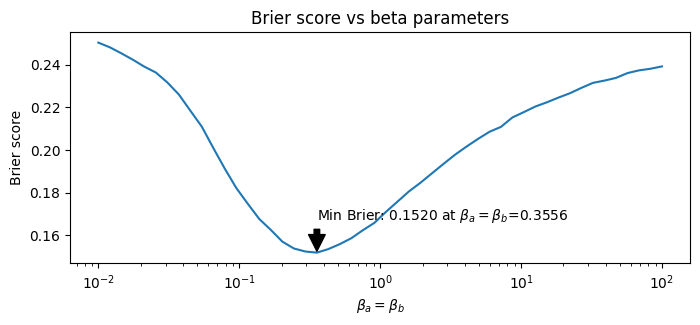

In [35]:
# Evaluate score over a parameter mesh with beta_a=beta_b and fixed weights
beta_range = np.logspace(-2, 2, 50)
parameter_mesh = util.generate_aggregate_meshgrid(
    *weights_original[1:], beta_range, equal_betas=True
)
score_vec = util.calculate_score_over_meshgrid(
    parameter_mesh,
    mean_ests,
    mean_ests_SF,
    mean_ests_FE,
    mean_ests_LW,
    resolution_vector,
)

fig = plt.figure(figsize=(8, 3))
ax = plot.score_vs_beta(beta_range, score_vec)
plt.show()

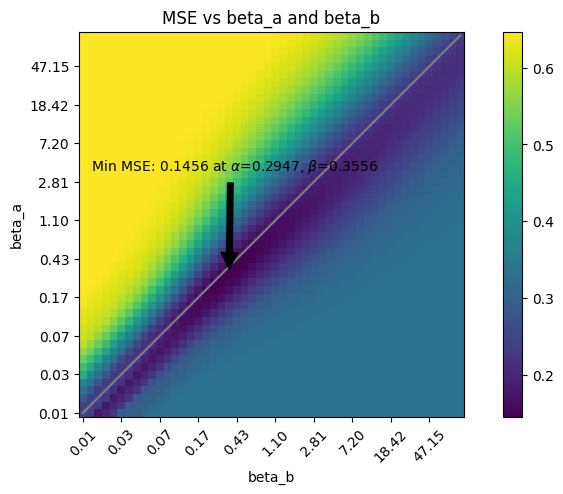

In [8]:
# Evaluate score over a parameter mesh of beta_a and beta_b and fixed weights

n_beta_range = 50
beta_range = np.logspace(-2, 2, n_beta_range)

parameter_mesh = util.generate_aggregate_meshgrid(
    *weights_original[1:], beta_range, equal_betas=False
)


score_vec = util.calculate_score_over_meshgrid(
    parameter_mesh,
    mean_ests,
    mean_ests_SF,
    mean_ests_FE,
    mean_ests_LW,
    resolution_vector,
)

score_grid = score_vec.reshape((len(beta_range), len(beta_range)))

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
fig.colorbar(ax.imshow(score_grid, interpolation="nearest", origin="lower"))
ax.set_title("MSE vs beta_a and beta_b")
ax.set_xlabel("beta_b")
ax.set_ylabel("beta_a")
# Correct the tick labels to show the actual values, but only show current number of ticks
target_ticks = 10
tick_interval = max(1, int(max(len(beta_range), len(beta_range)) / target_ticks))
# Set tick locations
ax.set_xticks(np.arange(0, len(beta_range), tick_interval))
ax.set_yticks(np.arange(0, len(beta_range), tick_interval))
# Set tick labels
ax.set_xticklabels([f"{b:.2f}" for b in beta_range[::tick_interval]], rotation=45)
ax.set_yticklabels([f"{a:.2f}" for a in beta_range[::tick_interval]])
# Add annotation of minimum value
min_idx = np.unravel_index(np.argmin(score_grid), score_grid.shape)
min_mse_beta = score_grid[min_idx]
min_beta_a = beta_range[min_idx[0]]
min_beta_b = beta_range[min_idx[1]]
ax.annotate(
    rf"  Min MSE: {min_mse_beta:.4f} at $\alpha$={min_beta_a:.4f}, $\beta$={min_beta_b:.4f}",
    xy=(min_idx[1], min_idx[0]),  # x, y coordinates for annotation point
    xytext=(min_idx[1] * 0.0, min_idx[0] * 1.75),  # Adjust text position
    arrowprops=dict(facecolor="black", shrink=0.05),
)
# Add line at beta_a==beta_b
ax.plot([0, len(beta_range) - 1], [0, len(beta_range) - 1], color="grey")
plt.show()

In [20]:
# Compute a full 6d mesh grid
n_points = 25
fixed_betas = True
if fixed_betas:
    beta_range = [1 / 3]
else:
    beta_range = np.linspace(1 / 5, 1 / 2, n_points)
weights_range = np.linspace(0, 1, n_points)
parameter_mesh = util.generate_aggregate_meshgrid(
    weights_range,
    weights_range,
    weights_range,
    beta_range,
    equal_betas=False,
)

print(f"Number of points in meshgrid: {len(parameter_mesh)}")

# Compute f over the meshgrid
score_vec = util.calculate_score_over_meshgrid(
    parameter_mesh,
    mean_ests,
    mean_ests_SF,
    mean_ests_FE,
    mean_ests_LW,
    resolution_vector,
)

print(f"Minimum score found in meshgrid: {np.min(score_vec)}")

Number of points in meshgrid: 2925
Minimum score found in meshgrid: 0.15112


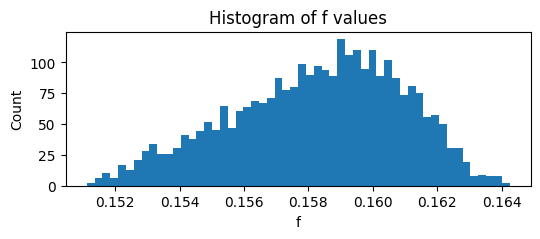

In [21]:
# Historam of f values
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.hist(score_vec, bins=np.round(np.sqrt(len(score_vec))).astype(int))
ax.set_title("Histogram of f values")
ax.set_xlabel("f")
ax.set_ylabel("Count")
plt.show()

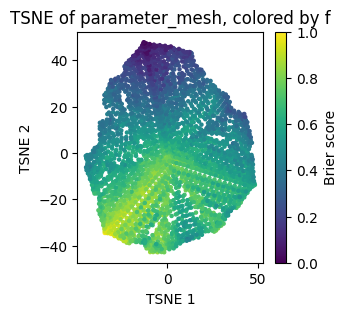

In [22]:
# Calculate TSNE of parameter_mesh, colored by f
tsne = TSNE(n_components=2, random_state=0)
tsne_weights = tsne.fit_transform(parameter_mesh)
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(tsne_weights[:, 0], tsne_weights[:, 1], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("TSNE of parameter_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

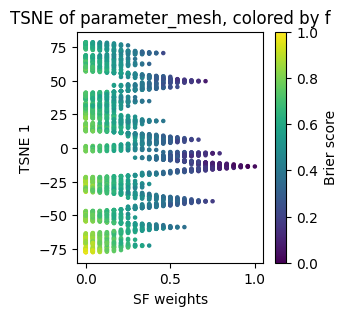

In [12]:
# Calculate a 1-d TSNE without the 2nd dimension of parameter_mesh, then plot
# the third dimension against the 1-d TSNE
tsne = TSNE(n_components=1, random_state=0)
tsne_weights = tsne.fit_transform(parameter_mesh[:, [0, 2, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(parameter_mesh[:, 1], tsne_weights[:, 0], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("SF weights")
ax.set_ylabel("TSNE 1")
ax.set_title("TSNE of parameter_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

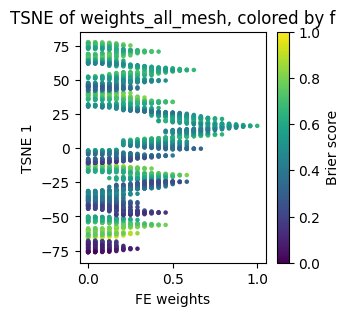

In [13]:
# Calculate a 1-d TSNE without the 2nd dimension of parameter_mesh, then plot
# the third dimension against the 1-d TSNE
tsne = TSNE(n_components=1, random_state=0)
tsne_weights = tsne.fit_transform(parameter_mesh[:, [0, 1, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(parameter_mesh[:, 2], tsne_weights[:, 0], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("FE weights")
ax.set_ylabel("TSNE 1")
ax.set_title("TSNE of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

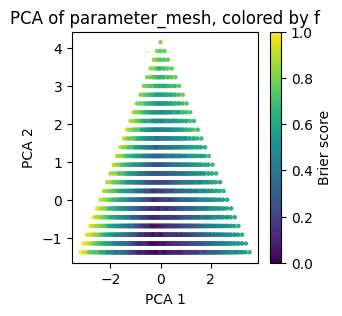

In [14]:
# Calculate PCA of parameter_mesh, colored by f
normalize_data = True
if normalize_data:
    pca_mesh = StandardScaler().fit_transform(parameter_mesh)
else:
    pca_mesh = parameter_mesh
pca = PCA(n_components=2)
pca_weights = pca.fit_transform(pca_mesh)
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(pca_weights[:, 0], pca_weights[:, 1], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("PCA of parameter_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

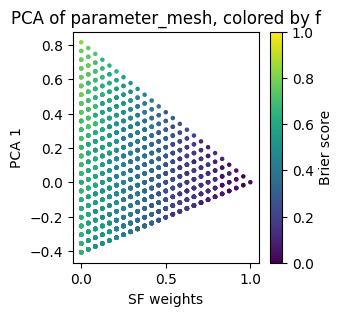

In [15]:
# Calculate a 1-d PCA without the third dimension of weights_all_mesh, then plot
# the third dimension against the 1-d PCA
pca = PCA(n_components=1)
pca_weights = pca.fit_transform(parameter_mesh[:, [0, 2, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(parameter_mesh[:, 1], pca_weights[:, 0], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("SF weights")
ax.set_ylabel("PCA 1")
ax.set_title("PCA of parameter_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

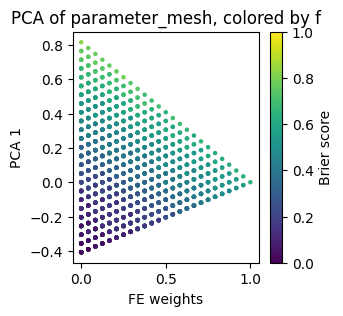

In [16]:
# Calculate a 1-d PCA without the third dimension of parameter_mesh, then plot
# the third dimension against the 1-d PCA
pca = PCA(n_components=1)
pca_weights = pca.fit_transform(parameter_mesh[:, [0, 1, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(parameter_mesh[:, 2], pca_weights[:, 0], s=5, c=score_vec, cmap="viridis")
ax.set_xlabel("FE weights")
ax.set_ylabel("PCA 1")
ax.set_title("PCA of parameter_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

## Optimized parameters

Use scipy optimize to find the optimal parameters

In [17]:
# Optimize the weights and beta_a, beta_b simultaneously

# Initial guess
weights_original = [0.05, 0.8, 0.1, 0.05]
weights = [0.25, 0.25, 0.25, 0.25]
beta_a = 1 / 3
beta_b = 1 / 3
x0 = weights + [beta_a, beta_b]
x0_original = weights_original + [beta_a, beta_b]
constraints = ({"type": "eq", "fun": util.aggregation_constraint_1},)
arguments = (mean_ests, mean_ests_SF, mean_ests_FE, mean_ests_LW, resolution_vector)
bounds = (
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (1 / 10, 1),
    (1 / 10, 1),
)

x0_original_string = ", ".join([f"{p:.6f}" for p in x0_original])
print(f"Original guess: {x0_original_string}")
x0_score = util.aggregation_score(x0_original, *arguments)
print(f"Score: {x0_score:.6f}")

# SciPy.optimize.minimize
print("Local optimization using minimize")
result = optimize.minimize(
    util.aggregation_score,
    x0,
    constraints=constraints,
    bounds=bounds,
    args=arguments,
    tol=1e-3,
    # method="Nelder-Mead",
    options={"maxiter": 1000000},
)

if result.success:
    fitted_params = result.x
    param_string = ", ".join([f"{p:.6f}" for p in fitted_params])
    print(f"Fitted params:  {param_string}")
    fitted_param_score = result.fun
    print(f"Score: {fitted_param_score:.6f}")
else:
    raise ValueError(result.message)

# Scipy.optimize.basinhopping
print("Global optimization")
optimization_method = "dual_annealing"
match optimization_method:
    case "basinhopping":
        result = optimize.basinhopping(
            util.validated_aggregation_score,
            x0,
            minimizer_kwargs={
                "bounds": bounds,
                "args": arguments,
            },
            niter=1000,
            disp=False,
            stepsize=0.01,
        )
    case "dual_annealing":
        result = optimize.dual_annealing(
            util.validated_aggregation_score,
            bounds,
            args=arguments,
            minimizer_kwargs={
                "constraints": constraints,
                "bounds": bounds,
            },
            maxiter=5000,  # High number of iterations
            initial_temp=5230,  # Default 5230
            # restart_temp_ratio=0.005,  # Low restart temperature ratio
            # visit=2.5,  # Default 2.62
            accept=-1e4,  # Higher acceptance of worse solutions
            maxfun=1e8,  # Default 1e7
            seed=1,
        )
    case _:
        raise ValueError(f"Unknown optimization method: {optimization_method}")

if result.success:
    fitted_params = result.x
    param_string = ", ".join([f"{p:.6f}" for p in fitted_params])
    print(f"Fitted params:  {param_string}")
    fitted_param_score = result.fun
    print(f"Score: {fitted_param_score:.6f}")
else:
    raise ValueError(result.message)

# Best so far:
# Fitted params:  0.343751, 0.656249, 0.000000, 0.000000, 0.316564, 0.381792
# Score: 0.146116

Original guess: 0.050000, 0.800000, 0.100000, 0.050000, 0.333333, 0.333333
Score: 0.153088
Local optimization using minimize
Fitted params:  0.250000, 0.250000, 0.250000, 0.250000, 0.333333, 0.333333
Score: 0.158232
Global optimization
Fitted params:  0.000000, 0.722385, 0.082014, 0.195602, 0.227142, 0.276849
Score: 0.147730
